В зависимости от количества классов $K$ выделяют **бинарную** (*binary*, $K=2$) и **многоклассовую** (*multiclass*, $K>2$) классификацию.

В случае многоклассовой классификации каждому объекту соответствует один класс. Однако возможны случаи, когда объект может относится сразу к нескольким классам. Например, текст может содержать несколько эмоций: удивление и радость, печаль и страх. Если объект имеет **более одной метки** (*label*), классификация становится **многометочной** (*multilabel*).

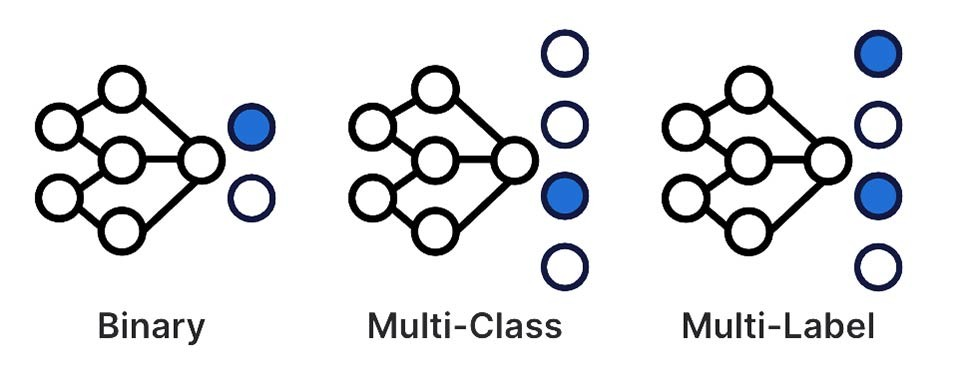

## Data-Driven Model for Emotion Detection in Russian Texts

Данная стратегия реализована в русскоязычном корпусе для распознавания эмоций, который создан сотрудниками НИЦ «Курчатовский институт» и представлен в следующей статье:

[Sboev A., Naumov A. & Rybka R. (2021). Data-Driven Model for Emotion Detection in Russian Texts](https://www.sciencedirect.com/science/article/pii/S1877050921013247?ref=pdf_download&fr=RR-2&rr=8c4724debf7b005c)

Корпус включает 9 668 предложений из нескольких источников:
- 3107 постов из социальной сети Livejournal
- 3131 текст из новостного издания Lenta.Ru
- 3430 постов из социальной сети Twitter (заблокирована на территории РФ)

Набор данных размечен **по 6 классам эмоций**: радость (joy),  печаль (sadness), злость (anger), страх (fear), удивление (surprise), без эмоций (no emotion).

Отбор текстов проводился по Словарю эмотивной лексики русского языка. Cписок слов-маркеров для каждой эмоции был сформирован вручную. Разбиение эмоциональной лексики по классам доступно в [гитхаб-репозитории](https://github.com/naumov-al/CEDR/tree/v_0.1.1_(actual)) одного из авторов статьи.

In [ ]:
!wget https://raw.githubusercontent.com/naumov-al/CEDR/master/data/emo_lexicon.json

Файл JSON — это множество пар «ключ: значение». Модуль `json` позволяет работать с файлами этого формата. Функция `load()` преобразует строку в формате JSON в словарь.

In [ ]:
import json
with open(f'emo_lexicon.json') as f:
    emo_lexicon_dict = json.load(f)
type(emo_lexicon_dict)

📌 Определите, что является ключами `.keys()` и значениями `.values()` словаря `emo_lexicon_dict`.

In [ ]:
# Место для вашего кода

Разметка корпуса осуществлялась вручную с помощью краудсорсинговой платформы Яндекс.Толока. Каждое предложение было размечено минимум 3 людьми. Разметчикам нужно было ответить на вопрос «Какие эмоции автор выразил в предложении?».

В качестве ответа требовалось поставить предложению произвольное количество следующих эмоциональных меток:
- Радость — выражает радость, удовольствие, доброту, дружелюбие, содержит символы «:)», «:D», «xD», «:P» или закрывающиеся скобки «)))»
- Гнев — выражат злость, агрессию, жестокость, ненависть или содержит оскорбления
- Печаль — выражает печаль, огорчение, жалость, одиночество, содержит символы «:(» или открывающие скобки «((((»
- Страх — выражает страх или тревогу; исключение составляют случаи использования слов «ужасный», «потрясающий» для усиления интенсивности эмоции (*Мне ужасно жаль* относится к классу «печаль»)
- Удивление — выражает впечатления о необычном, неожиданном или непонятном предмете, событии или явлении, содержит символы «О_о», «о_о», «Оо», «0_0» или слова «Ооооо», «вау», «с ума сойти»
- Если предложение не выражает эмоций, ему должен был быть присвоен ярлык «без эмоций».

Выбор окончательных меток осуществлялся следующим образом:
- Метка «без эмоций» — если менее 60% разметчиков присвоили предложению какую-либо эмоцию
- Метка определенной эмоции — если ее присвоили более 50% разметчиков

В итоге 5609 предложений содержали одну или несколько эмоций, а 4059 предложений не содержали ни одной.

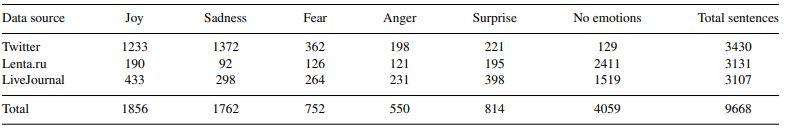

Как видно из таблицы, наибольшее количество эмоций содержится в текстах твитов, в то время как предложения из новостных статей редко отражают какие-либо эмоции, даже если они содержат эмоциональные слова.

Для многометочной классификации был создан **ансамбль** из пяти бинарных классификаторов (для всех классов кроме нейтрального). Каждый классификатор определяет, содержит ли предложение эмоцию, и присваивает соответствующую метку.

- Классификатор для эмоции «радость» — 1, если предложение выражает радость, 0 в остальных случаях
- Классификатор для эмоции «гнев» — 1, если предложение выражает гнев, 0 в остальных случаях
- Классификатор для эмоции «печаль» — 1, если предложение выражает печаль, 0 в остальных случаях
- Классификатор для эмоции «страх» — 1, если предложение выражает страх, 0 в остальных случаях
- Классификатор для эмоции «удивление» — 1, если предложение выражает удивление, 0 в остальных случаях
- Предложения относятся к нейтральному классу, если получают метку 0 ото всех пяти классификаторов

Для каждого класса были опробованы модели на основе разных алгоритмов. В итоге были выбраны классификаторы, которые показали наилучшее качество. Результаты ансамбля обозначены в строке Our ensemble.

При разработке модели машинного обучения полезно иметь некоторую baseline модель. Это позволит проконтролировать, что более сложная модель действительно дает прирост качества. В статье используется три baseline модели:
- Random — случайной присвоение эмоциональной метки
- Lexicon — классификация на основе словаря эмотивной лексики
- SVM (TF-IDF) — 5 классификаторов на основе метода опорных векторов с линейным ядром

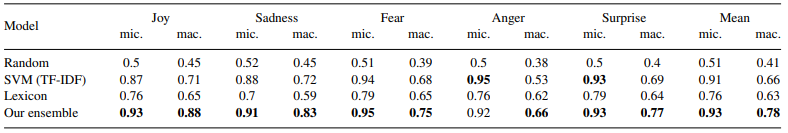

Поскольку для каждого класса создается свой классификатор, подсчет метрик также осуществляется отдельно. Вычисляется микро- и макроусредненная F-мера для каждого класса, затем полученные значения усредняются.

В гитхаб-репозитории статьи представлен [блокнот](https://github.com/naumov-al/CEDR/blob/v_0.1.1_(actual)/notebooks/Baseline_accuracy.ipynb) для получения метрик для каждого метода. Попробуем воспроизвести представленные в нем результаты.

## Corpus for Emotions Detecting in Russian-language text sentences

Набор данных, описанный в статье, назван **C**orpus for **E**motions **D**etecting in **R**ussian-language text sentences of different social sources (сокращенно **CEDR**). [Корпус](https://huggingface.co/datasets/cedr) доступен в библиотеке Datasets от Hugging Face.

In [ ]:
!pip install datasets -q

Для загрузки набора данных используется метод `load_dataset`.

Существует 2 конфигурации CEDR: основная (`main`) и расширенная (`enriched`). Для указания нужной конфигурации используется параметр `name`. По умолчанию скачивается основная конфигурация.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from datasets import load_dataset

cedr_main = load_dataset('cedr', name="main")
#cedr_main = load_dataset('cedr')
cedr_main

Набор данных является объектом класса DatasetDict. Он имеет ключи и значения.

In [ ]:
cedr_main.keys()

Данные уже разбиты на обучающую (`train`) и тестовую (`test`) выборки. По ключу 'train' можно получить все объекты обучающей выборки, по ключу 'test' — тестовой.

In [ ]:
cedr_main['train']

In [ ]:
cedr_main['test']

Каждая из выборок является объектом класса Dataset. Они состоят из определенного числа объектов (`num_rows`):
- 7528 предложений в обучающей выборке
- 1882 предложения в тестовой выборке

Общее количество предложений отличается от указанного в статье и равно 9410 предложений, поскольку были удалены дубликаты.

Каждый объект выборки имеет несколько атрибутов (`features`):
- тексты предложений (`text`)
- метки эмоций (`labels`)
- источник текста (`source`)

Конкретный объект датасета можно получить по индексу.

📌 Выведите первый и последний объект обучающей выборки.

In [ ]:
# Место для вашего кода

Каждый объект датасета является словарем, содержит ключи и значения.

📌 Выведите отдельно текст, метку класса и источник для любого объекта из обучающей выборки.

In [ ]:
# Место для вашего кода

📌 Загрузите расширенную конфигурацию датасета CEDR. Выведите какой-либо объект обучающей выборки и определите отличия от основной конфигурации.

In [ ]:
# Место для вашего кода

Запишем обучающую и тестовую выборку расширенного корпуса в отдельные переменные. Это можно сделать сразу при скачивании, указав значение параметра `split`.

In [ ]:
train_data = load_dataset('cedr', name='enriched', split='train')
test_data = load_dataset('cedr', name='enriched', split='test')

In [ ]:
train_data

In [ ]:
test_data

В наборе данных указаны только числовые метки классов, однако на странице датасета указано соотношение меток и названий эмоций. Запишем его в словарь.

In [ ]:
labels2emotion = {0: "joy", 1: "sadness", 2: "surprise", 3: "fear", 4: "anger"}

## Случайное определение класса

Для начала попробуем случайно предсказывать класс эмоции, рандомно генерируя метку класса (0 или 1).

Подсчет метрик будем осуществлять двумя способами:
- микро- и макроусредненная F-мера для каждого класса (как в статье)
- точность, полнота и F-мера для каждого класса и их усреднение (отчет о классификации)

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, classification_report

# матрица для записи правильных и предсказанных ответов
# её размер — количество объектов х количество классов
all_true = np.zeros((1882,6))
all_pred = np.zeros((1882,6))

# будем осуществлять проход по всем предложениям 5 раз (по количеству эмоций)
for emo_label in labels2emotion.keys():

    # правильные ответы для текущего класса
    true_y = []
    # для каждого предложения проверяем наличие эмоции среди списка меток
    for sample in test_data:
        if emo_label in sample['labels']:
            true_y.append(1)
        else:
            true_y.append(0)

    # предсказанные ответы для текущего класса
    # генерируем массив из 0 и 1 в случайном порядке
    pred_y = np.random.randint(0,2,len(test_data))

    # подсчитываем микро- и макроусредненную F-меру
    f_micro = f1_score(true_y, pred_y, average="micro")
    f_macro = f1_score(true_y, pred_y, average="macro")
    # выводим название класса и значения метрик
    print(f'Emotion "{labels2emotion[emo_label]}":')
    print(f'F-score\t micro: {round(f_micro, 2)};\tmacro:{round(f_macro, 2)}\n')

    # записываем ответы для всех объектов в столбец с соответвующим индексом
    all_true[:, emo_label] = np.array(true_y)
    all_pred[:, emo_label] = pred_y

# ответы для нейтрального класса определяются по остаточному принципу
# если сумма всех меток эмоций равна нулю, то присваивается нейтральный класс
all_pred[:, 5] = (np.sum(all_pred, axis=1)==0).astype(int)
all_true[:, 5] = (np.sum(all_true, axis=1)==0).astype(int)
# считаем и выводим метрики
f_micro = f1_score(all_true[:, 5], all_pred[:, 5], average="micro")
f_macro = f1_score(all_true[:, 5], all_pred[:, 5], average="macro")
print(f'No emotion')
print(f'F-score\t micro: {round(f_micro, 2)};\tmacro:{round(f_macro, 2)}\n')

# выводим отчет о классификации
target_names = ["joy", "sadness", "surprise", "fear", "anger", "no emotion"]
print(classification_report(all_true, all_pred, target_names=target_names))

Матрица правильных ответов для всех классов:

In [ ]:
all_true, all_true.shape

Матрица предсказанных ответов для всех классов:

In [ ]:
all_pred, all_pred.shape

Предсказанные ответы для одного класса:

In [ ]:
all_pred[:,0], all_pred[:,0].shape

В случае многометочной классификации рассчитывается четыре варианта усреднения:
- микроусреднение (усреднение на уровне матрицы ошибок)
- макроусреднение (усреднение на уровне метрик)
- взвешенное усреднение (взвешанная сумма метрик)
- выборочное усреднение (подсчет метрик для каждого объекта и усреднение)

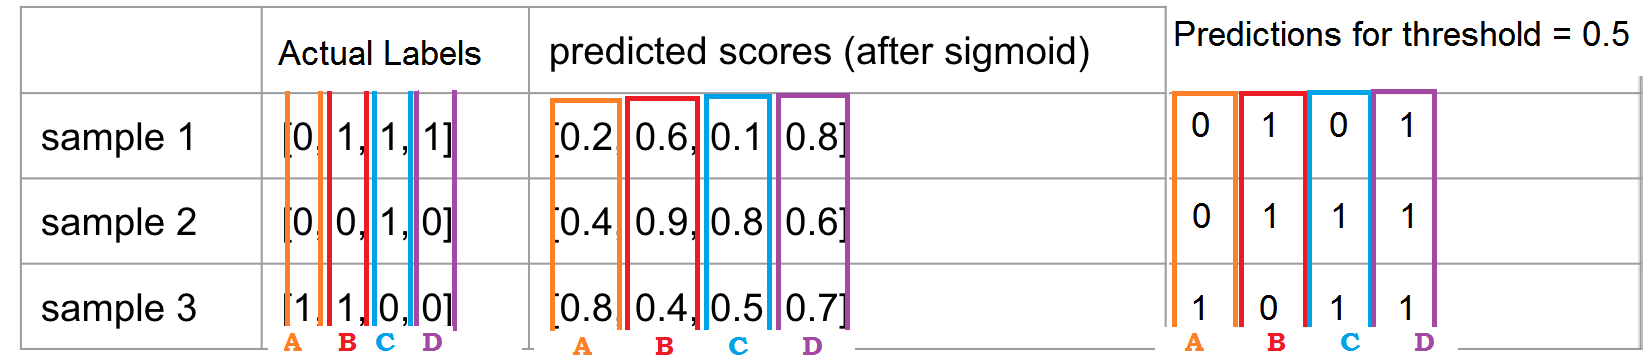

In [ ]:
sample_average_f1_score = 0
y_true = np.array([[0, 1, 1, 1], [0, 0, 1, 0], [1, 1, 0, 0]])
y_pred = np.array([[0, 1, 0, 1], [0, 1, 1, 1], [1, 0, 1, 1]])
for i in range (len(y_true)):
  sample_f1_score = f1_score(y_true[i,:], y_pred[i,:])
  sample_average_f1_score += sample_f1_score
  print("For sample {} f1-score: {:.2f} ".format(y_true[i,:], sample_f1_score))
print("Sample average f1-score: {:.2f}".format(sample_average_f1_score / len(y_true)))

## Cловарь эмоциональной лексики

Вторая baseline модель основана на словаре эмоциональной лексики для русского языка `emo_lexicon_dict`. Словарь содержит названия эмоций (ключи) и список соответствующих им лексем (значения).

In [ ]:
for k,v in emo_lexicon_dict.items():
  print(f"{k}: {v}")

Если в среди лемм предложения есть хотя бы одно слово, соответствующее эмоции в словаре, то предложению присваивается метка этого эмоционального класса.

In [ ]:
from sklearn.metrics import f1_score, classification_report

# матрица для записи правильных и предсказанных ответов
# её размер — количество объектов х количество классов
all_true = np.zeros((1882,6))
all_pred = np.zeros((1882,6))

# будем осуществлять проход по всем предложениям 5 раз (по количеству эмоций)
for emo_label in labels2emotion.keys():

    # правильные и предсказанные ответы для текущего класса
    true_y, pred_y = [], []

    # для каждого предложения проверяем наличие эмоции среди списка меток
    for sample in test_data:
        if emo_label in sample['labels']:
            true_y.append(1)
        else:
            true_y.append(0)

        # метка эмоции определяется наличием слов из эмоционального словаря для соответствующей эмоции
        sample_lemms = [word['lemma'].lower() for sentence in sample['sentences'] for word in sentence]
        if any(word in emo_lexicon_dict[labels2emotion[emo_label]] for word in sample_lemms):
            pred_y.append(1)
        else:
            pred_y.append(0)

    # подсчитываем микро- и макроусредненную F-меру
    f_micro = f1_score(true_y, pred_y, average="micro")
    f_macro = f1_score(true_y, pred_y, average="macro")
    # выводим название класса и значения метрик
    print(f'Emotion "{labels2emotion[emo_label]}":')
    print(f'F-score\t micro: {round(f_micro, 2)};\tmacro:{round(f_macro, 2)}\n')

    # записываем ответы для всех объектов в столбец с соответвующим индексом
    all_true[:, emo_label] = np.array(true_y)
    all_pred[:, emo_label] = pred_y

# ответы для нейтрального класса определяются по остаточному принципу
# если сумма всех меток эмоций равна нулю, то присваивается нейтральный класс
all_pred[:, 5] = (np.sum(all_pred, axis=1)==0).astype(int)
all_true[:, 5] = (np.sum(all_true, axis=1)==0).astype(int)
# считаем и выводим метрики
f_micro = f1_score(all_true[:, 5], all_pred[:, 5], average="micro")
f_macro = f1_score(all_true[:, 5], all_pred[:, 5], average="macro")
print(f'No emotion')
print(f'F-score\t micro: {round(f_micro, 2)};\tmacro:{round(f_macro, 2)}\n')

# выводим отчет о классификации
target_names = ["joy", "sadness", "surprise", "fear", "anger", "no emotion"]
print(classification_report(all_true, all_pred, target_names=target_names))

## Метод опорных векторов

Основной задачей алгоритма является найти наиболее правильную линию, или гиперплоскость разделяющую данные на два класса. Допустим, мы хотим отделить синие квадраты от зеленых кругов. Однако существует бесконечное количество линий, которые могут разделить эти два класса.

📌 Какая из двух линий (красная или зеленая) лучше всего разделяет два класса и подходит под описаниие «идеальной»?

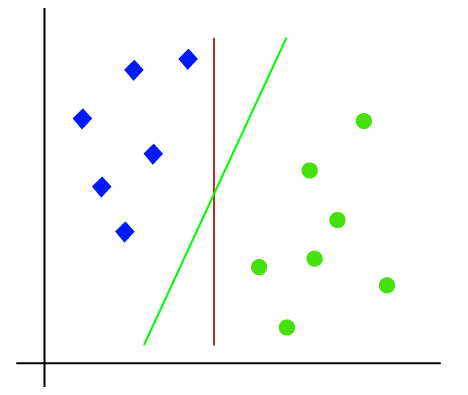

Алгоритм ищет точки на графике, которые расположены ближе всего к линии разделения. Эти точки называются **опорными векторами** (support vector). Затем алгоритм вычисляет расстояние между опорными векторами и разделяющей плоскостью. Это расстояние называется **зазором** (margin). Основная цель алгоритма — максимизировать расстояние зазора. **Лучшей гиперплоскостью** (optimal hyperplane) считается такая гиперплоскость, для которой этот зазор является максимально большим.

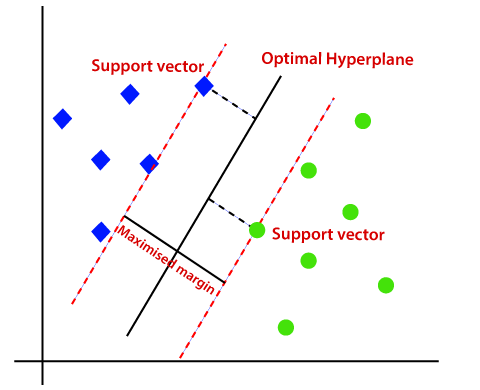

При многоклассовой классификации используется подход **«один против всех»**  (one vs. rest). Гиперплоскость должна отделять каждый класс от остальных.  Например, зеленая линия пытается максимально увеличить расстояние между зелеными точками и всеми остальными точками.

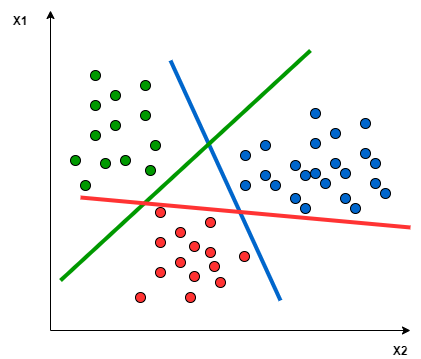

При переходе к алгоритмам машинного обучения необходимо вначале осуществить векторизацию. Создаем векторизатор `vect` на уровне символьных n-грамм, длина которых от 4 до 8 символов. Затем составляем словарь из n-грамм всех текстов `texts_for_fit`: и обучающей `train_data`, и тестовой `test_data` выборки.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(analyzer='char', ngram_range=(4,8))
texts_for_fit = [sample['text'].lower() for sample in train_data]
texts_for_fit += [sample['text'].lower() for sample in test_data]
vect.fit(texts_for_fit)

Создаем модель для классификации — метод опорных векторов с линейным ядром.

In [ ]:
from sklearn.svm import LinearSVC
model = LinearSVC(random_state=42)

Для распознавания каждого класса будет обучаться отдельный бинарный классификатор.

In [ ]:
from sklearn.metrics import f1_score, classification_report

# матрица для записи правильных и предсказанных ответов
# её размер — количество объектов х количество классов
all_true = np.zeros((1882,6))
all_pred = np.zeros((1882,6))

# будем осуществлять проход по всем предложениям 5 раз (по количеству эмоций)
for emo_label in labels2emotion.keys():
    # тексты обучающей и тестовой выборки
    train_x, test_x = [], []
    # ответы обучающей и тестовой выборки
    train_y, true_y = [], []
    # предсказанные ответы
    pred_y = []

    """ Обучение """
    # добавляем предложения в обучающую выборку
    for sample in train_data:
        train_x.append(sample['text'].lower())
        # для каждого предложения проверяем наличие эмоции среди списка меток
        if emo_label in sample['labels']:
            train_y.append(1)
        else:
            train_y.append(0)

    # преобразуем тексты обучающей выборки в векторы
    train_x = vect.transform(train_x)
    # обучаем модель
    model.fit(train_x, train_y)

    """ Тестирование """
    # добавляем предложения в тестовую выборку
    for sample in test_data:
        test_x.append(sample['text'].lower())
        # для каждого предложения проверяем наличие эмоции среди списка меток
        if emo_label in sample['labels']:
            true_y.append(1)
        else:
            true_y.append(0)

    # преобразуем тексты тестовой выборки в векторы
    test_x = vect.transform(test_x)
    # записываем предсказания обученной модели
    pred_y = model.predict(test_x)

    # подсчитываем микро- и макроусредненную F-меру
    f_micro = f1_score(true_y, pred_y, average="micro")
    f_macro = f1_score(true_y, pred_y, average="macro")
    # выводим название класса и значения метрик
    print(f'Emotion "{labels2emotion[emo_label]}":')
    print(f'F-score\t micro: {round(f_micro, 2)};\tmacro:{round(f_macro, 2)}\n')

    # записываем ответы для всех объектов в столбец с соответвующим индексом
    all_true[:, emo_label] = np.array(true_y)
    all_pred[:, emo_label] = pred_y

# ответы для нейтрального класса определяются по остаточному принципу
# если сумма всех меток эмоций равна нулю, то присваивается нейтральный класс
all_pred[:, 5] = (np.sum(all_pred, axis=1)==0).astype(int)
all_true[:, 5] = (np.sum(all_true, axis=1)==0).astype(int)
# считаем и выводим метрики
f_micro = f1_score(all_true[:, 5], all_pred[:, 5], average="micro")
f_macro = f1_score(all_true[:, 5], all_pred[:, 5], average="macro")
print(f'No emotion')
print(f'F-score\t micro: {round(f_micro, 2)};\tmacro:{round(f_macro, 2)}\n')

# выводим отчет о классификации
target_names = ["joy", "sadness", "surprise", "fear", "anger", "no emotion"]
print(classification_report(all_true, all_pred, target_names=target_names))

## Ансамбль классификаторов

В качестве новой модели авторы предлагают использовать ансамбль из пяти бинарных классификаторов. Для каждой эмоции были обучены классификаторы на основе нескольких алгоритмов:
- логистическая регрессия
- метод опорных векторов с линейным ядром
- градиентный бустинг

В ходе обучения случайного леса каждый базовый алгоритм строится независимо от остальных. Бустинг воплощает идею последовательного построения линейной комбинации алгоритмов. Каждый следующий алгоритм старается уменьшить ошибку текущего ансамбля.

После обучения и тестирования классификаторов по макроусредненной F1-мере отбираются лучшие для включения в ансамбль.

- модель для эмоции «гнев» ([anger_model.pkl](https://canvas.instructure.com/courses/7745797/files/228148917?module_item_id=94185064)) и модель для эмоции «печаль» ([sad_model.pkl](https://canvas.instructure.com/courses/7745797/files/228148879?module_item_id=94185037)) — логистическая регрессия
- модель для эмоции «радость» ([joy_model.pkl](https://canvas.instructure.com/courses/7745797/files/228148847?module_item_id=94185018)) и модель для эмоции «страх» ([fear_model.pkl](https://canvas.instructure.com/courses/7745797/files/228148913?module_item_id=94185063)) — метод опорных векторов с линейным ядром
- модель для эмоции «удивление» ([surprise_model.pkl](https://canvas.instructure.com/courses/7745797/files/228148898?module_item_id=94185056)) — градиентный бустинг

Для кодирования предложения используются векторные представления слов, полученные с помощью предварительно обученной языковой модели ELMo (**E**mbeddings from **L**anguage **Mo**dels).

[Peters M. E., Neumann M., Iyyer M., Gardner M., Clark C., Lee K., Zettlemoyer L. (2018) Deep contextualized word representations](https://arxiv.org/abs/1802.05365).

Языковая модель оценивает вероятность текущего слова при наличии заданного контекста. Для получения векторов ELMo используется двунаправленная языковая модель (bidirectional Language Model или biLM).

Модель вычисляет вероятность слова $w_t$.
Два прохода по тексту:
- прямой (forward):
  - вероятность слова при условии предшествующего контекста
  - $p(w_1,w_2,...,w_N) = \prod \limits_{t=1...N}p(w_t|w_1,w_2,...,w_{t-1})$
- обратный (backward):
  - вероятность слова при условии последующего контекста
  - $p(w_1,w_2,...,w_N) = \prod \limits_{t=1...N}p(w_t|w_{t+1},w_{t+2},...,w_N)$

Модель состоит из двух слоев. На каждом слое обучается двунаправленная модель долгой краткосрочной памяти (biLSTM).

Информация из прямого и обратного прохода на первом слое формирует промежуточные векторы слов, которые подаются на вход второго слоя модели. Результирующие векторы — взвешенная сумма необработанных векторов и двух промежуточных векторов.

ELMo строит **контекстуализированные векторные
представления слов**. Векторы присваиваются словам на основе их семантики в контексте предложения.

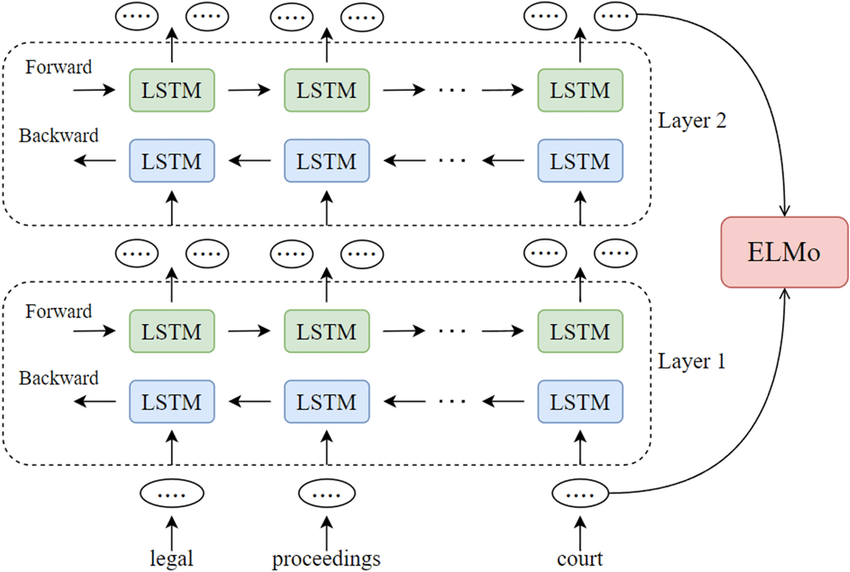

Векторные представления ELMo хранятся в файле [elmo_vec.pkl](https://canvas.instructure.com/courses/7745797/files/228148829?module_item_id=94185010). Он не доступен в гитхаб-репозитории статьи, однако был выслан автором по запросу.

Для использования векторных представлений и классификаторов, которые обучены авторами, необходимо использование более старых версий библиотек, чем установлены в гугл-колабе по умолчанию.

```
TPOT==0.11.1
xgboost==0.90
numpy==1.21.2
scikit-learn==0.22.1
scipy==1.9.1 deap==1.3.3
pandas==2.0.3
joblib==1.3.1
```
Для работы с ними требуется версия питона 3.8. Однако в колабе используется более новая версия питона, которая несовместима с данными версиями библиотек.

In [ ]:
!python --version

Использование этой версии возможно в Jupyter Notebook — веб-сервисе для записи и запуска кода на питоне. Для него можно установить конкретную версию питона, что позволяет использовать нужные нам версий библиотек. Код для использования предобученных моделей в юпитер-ноутбуке доступен в [блокноте](https://canvas.instructure.com/courses/7745797/files/228160212?module_item_id=94195258).

## OneVsRestClassifier для многометочной классификации

Более стандартный подход к многометочной классификации — использование встроенного класса `OneVsRestClassifier`. Он также создает отдельную модель для каждого класса.

Для классификации будем использовать не исходные предложения, а лемматизированные, то есть для каждого предложения объединим леммы слов в строку. Для этого понадобится функция предобработки текста `preprocessing`.

In [ ]:
def preprocessing(data):
  X = []
  for sample in data:
    sample_lemms = [word['lemma'].lower() for sentence in sample['sentences'] for word in sentence]
    X.append(' '.join(sample_lemms))
  return X

Применяем функцию к текстам. В качестве примера посмотрим, как было преобразовано одно из предложений.

In [ ]:
X_train = preprocessing(train_data)
X_test = preprocessing(test_data)
len(X_train), len(X_test)

In [ ]:
train_data[3], X_train[3]

Осуществляем векторизацию текста с помощью метода TF-IDF, отсеивая слишком редкие и слишком частые слова.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(min_df=5, max_df=0.5)
X_train_tf_idf = tf_idf.fit_transform(X_train)
X_test_tf_idf = tf_idf.transform(X_test)
X_train_tf_idf, X_test_tf_idf

Для многометочной классификации необходимо преобразовать метки класса в двоичную форму — вектор, где единицы соответствуют номеру класса. Это можно сделать с помощью [MultiLabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html).

Однако нейтральному классу не соответствуют никакие индексы. Поэтому создадим матрицу, где столбцов будет на один больше, чем меток классов. Затем присвоим метку нейтрального класса по остаточному принципу.

In [ ]:
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

y_train = np.zeros((7528,6))
y_test = np.zeros((1882,6))

mlb = MultiLabelBinarizer()
y_train[:,:5] = mlb.fit_transform(train_data['labels'])
y_test[:,:5] = mlb.fit_transform(test_data['labels'])

y_train, y_test

In [ ]:
y_test[:, 5] = (np.sum(y_test, axis=1)==0).astype(int)
y_train[:, 5] = (np.sum(y_train, axis=1)==0).astype(int)

y_train, y_test

Обучим модель для классификации — метод опорных векторов с линейным ядром с дефолтными параметрами. Выведем отчет о классификации.

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

linsvc_1 = OneVsRestClassifier(LinearSVC(random_state=42))
linsvc_1.fit(X_train_tf_idf, y_train)
y_linsvc_1 = linsvc_1.predict(X_test_tf_idf)
target_names = ['joy', 'sadness', 'surprise', 'fear', 'anger', 'no_emotion']
print(classification_report(y_test, y_linsvc_1, target_names=target_names))

Обратите внимание, что получившаяся модель `linsvc_1` относится к классу `OneVsRestClassifier`, то есть содержит внутри себя список из 6 разных моделей `linsvc_1.estimators_`.

In [ ]:
linsvc_1

In [ ]:
linsvc_1.estimators_

Для обученных классификаторов можно получить их коэффициенты $w_1,...,w_n$. Параметр `coef_ `есть у каждого элемента списка.

Метод опорных векторов создает гиперплоскость, которая использует опорные векторы для максимизации расстояния между классами. Расстояние (перпендикуляр) от каждого объекта до гиперплоскости равно $\frac{1}{||w||}$, где $||w||$ — норма вектора. При обучении находятся такие коэффициенты $w_1,...,w_n$, которые максимизируют расстояние до каждого класса.

Размер коэффициентов по отношению друг к другу может быть использован для определения важности признака: чем больше значение коэффициента, тем больше вклад признака

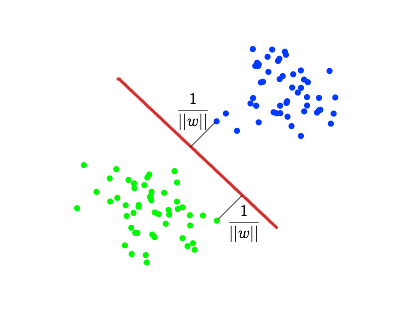

In [ ]:
linsvc_1.estimators_[0].coef_

Для поиска наилучших параметров модели воспользуемся алгоритмом `GridSearchCV`.

- параметр С

Когда значение C невелико, алгоритм фокусируется на достижении наибольшего расстояния между опорными векторами и разделяющей плоскостью. При большом значении C алгоритм стремится максимально классифицировать обучающие данные, что приводит к уменьшению зазора и переобучению.

- функция потерь (loss)

Метод опорных векторов использует кусочно-линейную функцию потерь (hinge loss). По умолчанию в sklearn считается квадрат функции потерь (squared hinge loss).

$L(y, f(x)) = max(0, 1 - y*f(x))$, где $y \in \{-1, +1\}$ — правильный ответ, а $f(x$) — предсказанный ответ для положительного класса. Если $y*f(x) >= 1$, то ошибка равна нулю, класс предсказан верно. Если $y*f(x) < 1$, то размер ошибки пропорционален расстоянию от правильного предсказания.


При использовании алгоритма `GridSearchCV` с объектом `OneVsRestClassifier` необходимо указывать параметры после названия класса `estimator` и двойного подчеркивания. Параметр `scoring` позволяет указывать метрику, которая будет подсчитываться для подбора наилучших параметров.

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {'estimator__C': np.arange(0,11),
              'estimator__loss': ['hinge', 'squared_hinge']}
model_to_set = OneVsRestClassifier(LinearSVC())

model_tunning = GridSearchCV(model_to_set, param_grid=parameters, scoring='f1_weighted')

model_tunning.fit(X_train_tf_idf, y_train)

print(model_tunning.best_score_)
print(model_tunning.best_params_)

📌 Обучите модель с параметрами, которые оказались наилучшими в соответствии с алгоритмом `GridSearchCV`. Выведите отчет о классификации. Сравните качество моделей.

In [ ]:
# Место для вашего кода

📌 Запишите в отдельную переменную `model_list` список классификаторов `.estimators_` модели, показавшей наилучший результат. Укажите список классов `labels` в правильном порядке. Для каждого класса выведите по 5 слов с самыми большими коэффициентами.

In [ ]:
model_list = # Место для вашего кода
labels = # Место для вашего кода

for i in range(len(model_list)):

    feature_names = tf_idf.get_feature_names_out()
    print(f"\n{labels[i]}:")

    class_coefficients = model_list[i].coef_.reshape(-1)
    order = class_coefficients.argsort()
    class_coefficients = class_coefficients[order][::-1][:5]
    feature_names = feature_names[order][::-1][:5]

    # Место для вашего кода